In [1]:
# Read SAS file
import pandas as pd

In [2]:
# NHANES 2007-2008 vaccination Immunization
nhanes0708_Vaccination = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/IMQ_E.XPT", format = "xport")

In [3]:
# NHANES 2007-2008 core antibody surface antigen
nhanes0708_BG = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/HEPBD_E.XPT", format = "xport" )

In [4]:
# NHANES 2007-2008 surface antibody
nhanes0708_Antibody = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/HEPB_S_E.XPT", format = "xport")

In [5]:
nhanes0708_Vaccination = nhanes0708_Vaccination[['SEQN','IMQ020']]

In [6]:
nhanes0708_BG = nhanes0708_BG[['SEQN','LBXHBC','LBDHBG']]

In [7]:
nhanes0708_Antibody

,SEQN,LBXHBS
0,41475.0,2.0
1,41476.0,1.0
2,41477.0,2.0
3,41479.0,1.0
4,41480.0,NaN
...,...,...
9008,51619.0,2.0
9009,51620.0,2.0
9010,51621.0,1.0
9011,51622.0,2.0


In [8]:
nhanes0708_No_vaccination = nhanes0708_Vaccination[(nhanes0708_Vaccination['IMQ020']==3.0) | (nhanes0708_Vaccination['IMQ020']==7.0) | (nhanes0708_Vaccination['IMQ020']==9.0)]

In [9]:
nhanes0708_No_vaccination

,SEQN,IMQ020
0,41475.0,3.0
2,41477.0,3.0
7,41482.0,3.0
8,41483.0,3.0
10,41485.0,9.0
...,...,...
10142,51617.0,9.0
10143,51618.0,3.0
10144,51619.0,3.0
10145,51620.0,9.0


In [10]:
nhanes0708_club_1 = pd.merge(nhanes0708_No_vaccination, nhanes0708_Antibody, on="SEQN", how = "left")

In [11]:
nhanes0708_club_2 = pd.merge(nhanes0708_club_1, nhanes0708_BG, on="SEQN", how = "left")

In [12]:
import pandas as pd
import pandas.io.sql as sqlio

In [13]:
pip install pandasql

Note: you may need to restart the kernel to use updated packages.


In [14]:
from pandasql import sqldf

In [15]:
query = '''
SELECT SEQN, (CASE WHEN LBXHBC = 1.0 THEN 'Positive' WHEN LBXHBC = 2.0 THEN 'Negative' WHEN LBXHBC IS NULL THEN 'Missing' END) AS Core_Antibody,
(CASE WHEN LBDHBG = 1.0 THEN 'Positive' WHEN LBDHBG = 2.0 THEN 'Negative' WHEN LBDHBG IS NULL THEN 'Missing' END) AS Surface_Antigen,
(CASE WHEN LBXHBS = 1.0 THEN 'Positive' WHEN LBXHBS = 2.0 THEN 'Negative' WHEN LBXHBS IS NULL THEN 'Missing' END) AS Surface_Antibody,
(CASE WHEN IMQ020 = 3.0 THEN 'No Doses' WHEN IMQ020 = 7.0 THEN 'Refused' WHEN IMQ020 = 9.0 THEN "Don't know" END) AS Vaccination
FROM nhanes0708_club_2
'''

In [16]:
nhanes0708_final = sqldf(query)

In [17]:
nhanes0708_final

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination
0,41475.0,Negative,Negative,Negative,No Doses
1,41477.0,Negative,Negative,Negative,No Doses
2,41482.0,Negative,Negative,Negative,No Doses
3,41483.0,Negative,Negative,Negative,No Doses
4,41485.0,Negative,Negative,Negative,Don't know
...,...,...,...,...,...
5116,51617.0,Positive,Negative,Positive,Don't know
5117,51618.0,Negative,Negative,Negative,No Doses
5118,51619.0,Negative,Negative,Negative,No Doses
5119,51620.0,Negative,Negative,Negative,Don't know


In [18]:
query2 = '''
SELECT SEQN, Core_Antibody, Surface_Antigen, Surface_Antibody, Vaccination, 
(CASE WHEN Surface_Antigen = 'Positive' THEN 'HBV Infection' WHEN (Surface_Antibody = 'Positive') THEN 'Vaccine Immunity' 
WHEN (Surface_Antigen = 'Negative' and Core_Antibody ='Negative' and Surface_Antibody ='Negative') THEN 'No Infection'
WHEN (Core_Antibody = 'Positive' and Surface_Antibody = 'Negative') THEN 'HBV Exposure' END) AS resp_2 
FROM nhanes0708_final
'''

In [19]:
nhanes0708_final_resp = sqldf(query2)

In [20]:
nhanes0708_final_resp[nhanes0708_final_resp['resp_2'].isna()]

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2
11,41497.0,Missing,Missing,Missing,No Doses,None
16,41505.0,Missing,Missing,Missing,Don't know,None
28,41521.0,Missing,Missing,Missing,Don't know,None
34,41528.0,Missing,Missing,Missing,No Doses,None
35,41535.0,Missing,Missing,Missing,No Doses,None
...,...,...,...,...,...,...
5090,51575.0,Missing,Missing,Missing,No Doses,None
5092,51578.0,Missing,Missing,Missing,Don't know,None
5101,51591.0,Missing,Missing,Missing,No Doses,None
5106,51602.0,Missing,Missing,Missing,No Doses,None


In [21]:
nhanes0708_HBV = nhanes0708_final_resp[(nhanes0708_final_resp['resp_2']=='HBV Infection') | (nhanes0708_final_resp['resp_2']=='No Infection')]

In [22]:
# NHANES 2017-2018 Demographic Variable
nhanes0708_Demographic = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/DEMO_E.XPT", format = "xport")

In [23]:
#changed columns 'RIDRETH1','DMQMILIT','DMDBORN', deleted 'DMQADFC' 
Demographic_Variables = ['SEQN','SDDSRVYR','RIAGENDR','RIDAGEYR','RIDRETH1','DMQMILIT','DMDBORN2','DMDCITZN',
                        'DMDYRSUS','DMDEDUC2','DMDMARTL','WTINT2YR','WTMEC2YR','SDMVPSU','SDMVSTRA','INDFMPIR']

In [24]:
nhanes0708_Demographic = nhanes0708_Demographic[Demographic_Variables]

In [25]:
nhanes0708_HBV_Demo = pd.merge(nhanes0708_HBV, nhanes0708_Demographic, on="SEQN", how = "left")

In [26]:
nhanes0708_HBV_Demo

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,SDDSRVYR,RIAGENDR,RIDAGEYR,RIDRETH1,...,DMDBORN2,DMDCITZN,DMDYRSUS,DMDEDUC2,DMDMARTL,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDFMPIR
0,41475.0,Negative,Negative,Negative,No Doses,No Infection,5.0,2.0,62.0,5.0,...,1.0,1.0,NaN,3.0,1.0,59356.356426,60045.772497,1.0,60.0,1.83
1,41477.0,Negative,Negative,Negative,No Doses,No Infection,5.0,1.0,71.0,3.0,...,1.0,1.0,NaN,3.0,1.0,9935.266183,10074.150074,1.0,67.0,1.50
2,41482.0,Negative,Negative,Negative,No Doses,No Infection,5.0,1.0,64.0,1.0,...,2.0,2.0,7.0,2.0,1.0,9811.075078,11602.178638,2.0,65.0,4.01
3,41483.0,Negative,Negative,Negative,No Doses,No Infection,5.0,1.0,66.0,4.0,...,1.0,1.0,NaN,4.0,1.0,8058.685296,7920.812275,2.0,66.0,1.14
4,41485.0,Negative,Negative,Negative,Don't know,No Infection,5.0,2.0,30.0,2.0,...,4.0,1.0,4.0,2.0,1.0,19055.790060,18849.664396,2.0,71.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3710,51611.0,Negative,Negative,Negative,No Doses,No Infection,5.0,2.0,55.0,3.0,...,5.0,1.0,9.0,4.0,3.0,87778.705525,90642.023851,1.0,65.0,4.95
3711,51613.0,Negative,Negative,Negative,Don't know,No Infection,5.0,1.0,13.0,3.0,...,1.0,1.0,NaN,NaN,NaN,36824.003958,37705.152054,1.0,61.0,1.51
3712,51618.0,Negative,Negative,Negative,No Doses,No Infection,5.0,1.0,48.0,3.0,...,1.0,1.0,NaN,5.0,1.0,83207.549908,84181.537996,1.0,74.0,3.83
3713,51619.0,Negative,Negative,Negative,No Doses,No Infection,5.0,1.0,61.0,1.0,...,2.0,1.0,7.0,1.0,1.0,5197.083889,5390.204907,2.0,71.0,2.75


In [27]:
nhanes0708_Insurance = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/HIQ_E.XPT", format = "xport")

In [28]:
Insurance_Variables = ['SEQN','HIQ011','HIQ031A','HIQ031B','HIQ031C','HIQ031D','HIQ031E','HIQ031H','HIQ031I','HIQ031AA']

In [29]:
nhanes0708_Insurance = nhanes0708_Insurance[Insurance_Variables]

In [30]:
nhanes0708_HBV_Demo_Insurance = pd.merge(nhanes0708_HBV_Demo, nhanes0708_Insurance, on="SEQN", how = "left")

In [31]:
query4 = '''
SELECT *, 
(CASE WHEN HIQ011 = 2.0 THEN 1 ELSE 0 END) AS No_Insurance,
(CASE WHEN HIQ011 = 1.0 and HIQ031A = 14.0 THEN 1 ELSE 0 END) AS Private_Insurance,
(CASE WHEN HIQ011 = 1.0 and (HIQ031A IS NOT NULL OR HIQ031B IS NOT NULL OR HIQ031C IS NOT NULL OR HIQ031D IS NOT NULL OR 
HIQ031E IS NOT NULL OR HIQ031H IS NOT NULL OR HIQ031I IS NOT NULL OR HIQ031AA IS NOT NULL) THEN 1 ELSE 0 END) Governement_Insurance
FROM nhanes0708_HBV_Demo_Insurance
'''

In [32]:
nhanes0708_HBV_Demo_Insurance = sqldf(query4)

In [33]:
nhanes0708_HBV_Demo_Insurance = nhanes0708_HBV_Demo_Insurance.drop(columns=['HIQ011','HIQ031A','HIQ031B','HIQ031C','HIQ031D','HIQ031E','HIQ031H','HIQ031I','HIQ031AA'])

In [34]:
nhanes0708_HBV_Demo_Insurance

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,SDDSRVYR,RIAGENDR,RIDAGEYR,RIDRETH1,...,DMDEDUC2,DMDMARTL,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDFMPIR,No_Insurance,Private_Insurance,Governement_Insurance
0,41475.0,Negative,Negative,Negative,No Doses,No Infection,5.0,2.0,62.0,5.0,...,3.0,1.0,59356.356426,60045.772497,1.0,60.0,1.83,1,0,0
1,41477.0,Negative,Negative,Negative,No Doses,No Infection,5.0,1.0,71.0,3.0,...,3.0,1.0,9935.266183,10074.150074,1.0,67.0,1.50,0,0,1
2,41482.0,Negative,Negative,Negative,No Doses,No Infection,5.0,1.0,64.0,1.0,...,2.0,1.0,9811.075078,11602.178638,2.0,65.0,4.01,0,1,1
3,41483.0,Negative,Negative,Negative,No Doses,No Infection,5.0,1.0,66.0,4.0,...,4.0,1.0,8058.685296,7920.812275,2.0,66.0,1.14,0,1,1
4,41485.0,Negative,Negative,Negative,Don't know,No Infection,5.0,2.0,30.0,2.0,...,2.0,1.0,19055.790060,18849.664396,2.0,71.0,1.01,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3710,51611.0,Negative,Negative,Negative,No Doses,No Infection,5.0,2.0,55.0,3.0,...,4.0,3.0,87778.705525,90642.023851,1.0,65.0,4.95,0,1,1
3711,51613.0,Negative,Negative,Negative,Don't know,No Infection,5.0,1.0,13.0,3.0,...,NaN,NaN,36824.003958,37705.152054,1.0,61.0,1.51,0,1,1
3712,51618.0,Negative,Negative,Negative,No Doses,No Infection,5.0,1.0,48.0,3.0,...,5.0,1.0,83207.549908,84181.537996,1.0,74.0,3.83,0,1,1
3713,51619.0,Negative,Negative,Negative,No Doses,No Infection,5.0,1.0,61.0,1.0,...,1.0,1.0,5197.083889,5390.204907,2.0,71.0,2.75,1,0,0


In [35]:
#Alcohol use
nhanes0708_Alcohol = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/ALQ_E.XPT", format = "xport")

In [36]:
nhanes0708_Alcohol = nhanes0708_Alcohol[['SEQN','ALQ130']]

In [37]:
nhanes0708 = pd.merge(nhanes0708_HBV_Demo_Insurance, nhanes0708_Alcohol, on="SEQN", how = "left")

In [38]:
#Healthcare Visits
nhanes0708_Healthcare = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/HUQ_E.XPT", format = "xport")

In [39]:
nhanes0708_Healthcare = nhanes0708_Healthcare [['SEQN','HUQ050']]

In [40]:
nhanes0708 = pd.merge(nhanes0708, nhanes0708_Healthcare, on="SEQN", how = "left")

In [41]:
#Dialysis
nhanes0708_Dialysis = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/KIQ_U_E.XPT", format = "xport")

In [42]:
nhanes0708_Dialysis = nhanes0708_Dialysis[['SEQN','KIQ025']]

In [43]:
nhanes0708 = pd.merge(nhanes0708, nhanes0708_Dialysis, on="SEQN", how = "left")

In [44]:
#Liver Condition
nhanes0708_Liver_Condition = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/MCQ_E.XPT", format = "xport")

In [45]:
nhanes0708_Liver_Condition = nhanes0708_Liver_Condition[['SEQN','MCQ160L']]

In [46]:
nhanes0708 = pd.merge(nhanes0708, nhanes0708_Liver_Condition, on="SEQN", how = "left")

In [47]:
#Blood Transfusion
nhanes0708_Blood_Transfusion = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/MCQ_E.XPT", format = "xport")

In [48]:
nhanes0708_Blood_Transfusion = nhanes0708_Blood_Transfusion[['SEQN','MCQ092']]

In [49]:
nhanes0708 = pd.merge(nhanes0708, nhanes0708_Blood_Transfusion, on="SEQN", how = "left")

In [50]:
#Healthcare Visits time
nhanes0708_Healthcare_time = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/HUQ_E.XPT", format = "xport")

In [51]:
nhanes0708_Healthcare_time = nhanes0708_Healthcare_time[['SEQN','HUQ060']]

In [52]:
nhanes0708 = pd.merge(nhanes0708, nhanes0708_Healthcare_time, on="SEQN", how = "left")

In [53]:
#Hepatitis C
nhanes0708_Hepatitis_C = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/HCQ_E.XPT", format = "xport")

In [54]:
nhanes0708_Hepatitis_C = nhanes0708_Hepatitis_C[['SEQN']]

In [55]:
import numpy as np
nhanes0708_Hepatitis_C['Hepatitis_C'] = "Yes"

In [56]:
nhanes0708 = pd.merge(nhanes0708, nhanes0708_Hepatitis_C, on="SEQN", how = "left")

In [57]:
Biochemistry_Variables = ['SEQN','LBXSATSI','LBDSALSI','LBXSASSI']

In [58]:
#Biochemistry_Variables
nhanes0708_Biochemistry_Variables = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/BIOPRO_E.XPT", format = "xport")

In [59]:
nhanes0708_Biochemistry_Variables = nhanes0708_Biochemistry_Variables[Biochemistry_Variables]

In [60]:
nhanes0708 = pd.merge(nhanes0708, nhanes0708_Biochemistry_Variables, on="SEQN", how = "left")

In [61]:
#Platelet count
nhanes0708_Platelet_count= pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/CBC_E.XPT", format = "xport")

In [62]:
nhanes0708_Platelet_count = nhanes0708_Platelet_count[['SEQN','LBXPLTSI']]

In [63]:
nhanes0708 = pd.merge(nhanes0708, nhanes0708_Platelet_count, on="SEQN", how = "left")

In [64]:
nhanes0708 = nhanes0708[nhanes0708['RIDAGEYR']>=18]

In [65]:
pd.set_option('display.max_columns', None)
nhanes0708.head()

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,SDDSRVYR,RIAGENDR,RIDAGEYR,RIDRETH1,DMQMILIT,DMDBORN2,DMDCITZN,DMDYRSUS,DMDEDUC2,DMDMARTL,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDFMPIR,No_Insurance,Private_Insurance,Governement_Insurance,ALQ130,HUQ050,KIQ025,MCQ160L,MCQ092,HUQ060,Hepatitis_C,LBXSATSI,LBDSALSI,LBXSASSI,LBXPLTSI
0,41475.0,Negative,Negative,Negative,No Doses,No Infection,5.0,2.0,62.0,5.0,2.0,1.0,1.0,NaN,3.0,1.0,59356.356426,60045.772497,1.0,60.0,1.83,1,0,0,NaN,3.000000e+00,NaN,2.0,2.0,NaN,NaN,26.0,36.0,24.0,366.0
1,41477.0,Negative,Negative,Negative,No Doses,No Infection,5.0,1.0,71.0,3.0,1.0,1.0,1.0,NaN,3.0,1.0,9935.266183,10074.150074,1.0,67.0,1.50,0,0,1,NaN,2.000000e+00,2.0,2.0,2.0,NaN,NaN,20.0,45.0,20.0,273.0
2,41482.0,Negative,Negative,Negative,No Doses,No Infection,5.0,1.0,64.0,1.0,2.0,2.0,2.0,7.0,2.0,1.0,9811.075078,11602.178638,2.0,65.0,4.01,0,1,1,4.0,1.000000e+00,NaN,1.0,2.0,NaN,NaN,42.0,45.0,35.0,239.0
3,41483.0,Negative,Negative,Negative,No Doses,No Infection,5.0,1.0,66.0,4.0,1.0,1.0,1.0,NaN,4.0,1.0,8058.685296,7920.812275,2.0,66.0,1.14,0,1,1,NaN,3.000000e+00,NaN,2.0,2.0,NaN,NaN,19.0,35.0,23.0,205.0
4,41485.0,Negative,Negative,Negative,Don't know,No Infection,5.0,2.0,30.0,2.0,2.0,4.0,1.0,4.0,2.0,1.0,19055.790060,18849.664396,2.0,71.0,1.01,1,0,0,NaN,5.397605e-79,NaN,2.0,2.0,2.0,NaN,15.0,44.0,17.0,465.0


In [66]:
nhanes0708.shape

(3556, 35)

In [67]:
nhanes0708 = nhanes0708

In [68]:
nhanes0708 = nhanes0708.rename(columns = {'SEQN':'Respondent_sequence_number',
                            'SDDSRVYR':'Data_release_cycle',
                            'RIAGENDR':'Gender',
                            'RIDAGEYR':'Age',
                            'RIDRETH1':'Race_Ethnicity',
                            'DMQMILIT':'Veteran_Status',
                            'DMDBORN2':'Country_of_birth',
                            'DMDCITZN':'Citizenship_status',
                            'DMDYRSUS':'Length_of_time_in_US',
                            'DMDEDUC2':'Education_level',
                            'DMDMARTL':'Marital_status',
                            'WTINT2YR':'Two_year_interview_weight',
                            'WTMEC2YR':'Two_year_MEC_weight',
                            'SDMVPSU':'Masked_variance_PSU',
                            'SDMVSTRA':'Masked_variance_stratum',
                            'INDFMPIR':'Ratio_income_poverty',
                            'ALQ130':'Alcohol_1_year',
                            'HUQ050':'Health_care_1_year',
                            'KIQ025':'Dialysis_1_year',
                            'MCQ160L':'liver_condition',
                            'MCQ092':'Blood_Transfusion',
                            'HUQ060':'Last_Healthcare_Visit',
                            'Hepatitis_C':'Hepatitis_C',
                            'LBXSATSI':'ALT',
                            'LBDSALSI':'Albumin',
                            'LBXSASSI':'AST',
                            'LBXPLTSI':'Platelet_Count'})

In [69]:
nhanes0708[nhanes0708['resp_2']=='HBV Infection'].shape

(11, 35)

In [70]:
import numpy as np
column_mapping = {
    'Gender':{1.0:"male", 2.0:"Female", np.nan:"missing"},
    'Race_Ethnicity':{1.0:"Mexican American",2.0:"Other Hispanic",3.0:"Non-Hispanic White",4.0:"Non-Hispanic Black",6.0:"Non-Hispanic Asian",7.0:"Other Race - Including Multi-Racial"},
    'Veteran_Status':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know", np.nan:"missing"},
    'Foreign_country':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know", np.nan:"missing"},
    'Country_of_birth':{1.0:"US", 2.0:"Other", 4.0:"Other", 5.0:"Other", 7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'Citizenship_status':{1.0:"Citizen",2.0:"Not a citizen",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'Length_of_time_in_US':{1.0:"Less than 1 year",2.0:"1-5",3.0:"5-10",4.0:"10-15",5.0:"15-20",6.0:"20-30",7.0:"30-40",8.0:"40-50",9.0:"50 or more",77.0:"Refused",88.0:"Could not determine",99.0:"Don't know",np.nan:"missing"},
    'Education_level':{1.0:"Less Than 9th Grade",2.0:"9-12th Grade",3.0:"High School Grad/GED or Equivalent",4.0:"Some College or AA degree",5.0:"College Graduate or above",7.0:"Refused",9.0:"Don't Know",np.nan:"missing"},
    'Marital_status':{1.0:"Married",2.0:"Widowed",3.0:"Divorced",4.0:"Separated",5.0:"Never married",6.0:"Living with partner",77.0:"Refused",99.0:"Don't know",np.nan:"missing"},
    'HH_Country_of_Birth':{1.0:"US", 2.0:"Other",77.0:"Refused",99.0:"Don't know",np.nan:"missing"},
    'Health_care_1_year':{5.397605e-79:"None",1.0:"1",2.0:"2 to 3",3.0:"4 to 9",4.0:"10 to 12",5.0:"13 or more",77.0:"Refused",99.0:"Don't know",np.nan:"missing"},
    'Dialysis_1_year':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'liver_condition':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'Blood_Transfusion':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'Last_Healthcare_Visit':{1.0:"6 months or less",2.0:"More than 6 months, but not more than 1 year ago",3.0:"More than 1 year, but not more than 3 years ago",4.0:"More than 3 years",5.0:"Never",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'Hepatitis_C_evertold':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know",np.nan:"missing"}
}

In [71]:
nhanes0708.replace(column_mapping,inplace=True)

In [72]:
for i in list(nhanes0708.columns):
    print(i, ":", nhanes0708[(nhanes0708[i]=='missing') | (nhanes0708[i].isna())].shape[0]*100.0/nhanes0708.shape[0])

Respondent_sequence_number : 0.0
Core_Antibody : 0.0
Surface_Antigen : 0.0
Surface_Antibody : 0.0
Vaccination : 0.0
resp_2 : 0.0
Data_release_cycle : 0.0
Gender : 0.0
Age : 0.0
Race_Ethnicity : 0.0
Veteran_Status : 0.0
Country_of_birth : 0.0
Citizenship_status : 0.0281214848143982
Length_of_time_in_US : 76.88413948256468
Education_level : 0.7592800899887514
Marital_status : 0.7592800899887514
Two_year_interview_weight : 0.0
Two_year_MEC_weight : 0.0
Masked_variance_PSU : 0.0
Masked_variance_stratum : 0.0
Ratio_income_poverty : 9.167604049493812
No_Insurance : 0.0
Private_Insurance : 0.0
Governement_Insurance : 0.0
Alcohol_1_year : 43.02587176602925
Health_care_1_year : 0.0
Dialysis_1_year : 96.9347581552306
liver_condition : 0.7592800899887514
Blood_Transfusion : 0.0
Last_Healthcare_Visit : 82.98650168728909
Hepatitis_C : 98.56580427446569
ALT : 0.562429696287964
Albumin : 0.5061867266591676
AST : 0.562429696287964
Platelet_Count : 0.2249718785151856


In [73]:
#Remove Last Healthcare Visits
#Remove Length_of_time_in_Us
#Remove Dialysis_1_year

In [74]:
nhanes0708 = nhanes0708.drop(columns=['Dialysis_1_year','Last_Healthcare_Visit','Length_of_time_in_US'])

In [75]:
nhanes0708

,Respondent_sequence_number,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,Data_release_cycle,Gender,Age,Race_Ethnicity,Veteran_Status,Country_of_birth,Citizenship_status,Education_level,Marital_status,Two_year_interview_weight,Two_year_MEC_weight,Masked_variance_PSU,Masked_variance_stratum,Ratio_income_poverty,No_Insurance,Private_Insurance,Governement_Insurance,Alcohol_1_year,Health_care_1_year,liver_condition,Blood_Transfusion,Hepatitis_C,ALT,Albumin,AST,Platelet_Count
0,41475.0,Negative,Negative,Negative,No Doses,No Infection,5.0,Female,62.0,5.0,No,US,Citizen,High School Grad/GED or Equivalent,Married,59356.356426,60045.772497,1.0,60.0,1.83,1,0,0,NaN,4 to 9,No,No,NaN,26.0,36.0,24.0,366.0
1,41477.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,71.0,Non-Hispanic White,Yes,US,Citizen,High School Grad/GED or Equivalent,Married,9935.266183,10074.150074,1.0,67.0,1.50,0,0,1,NaN,2 to 3,No,No,NaN,20.0,45.0,20.0,273.0
2,41482.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,64.0,Mexican American,No,Other,Not a citizen,9-12th Grade,Married,9811.075078,11602.178638,2.0,65.0,4.01,0,1,1,4.0,1,Yes,No,NaN,42.0,45.0,35.0,239.0
3,41483.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,66.0,Non-Hispanic Black,Yes,US,Citizen,Some College or AA degree,Married,8058.685296,7920.812275,2.0,66.0,1.14,0,1,1,NaN,4 to 9,No,No,NaN,19.0,35.0,23.0,205.0
4,41485.0,Negative,Negative,Negative,Don't know,No Infection,5.0,Female,30.0,Other Hispanic,No,Other,Citizen,9-12th Grade,Married,19055.790060,18849.664396,2.0,71.0,1.01,1,0,0,NaN,0.0,No,No,NaN,15.0,44.0,17.0,465.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3709,51610.0,Negative,Negative,Negative,No Doses,No Infection,5.0,Female,69.0,Mexican American,No,Other,Not a citizen,Less Than 9th Grade,Widowed,4865.131732,4805.998976,2.0,74.0,NaN,0,0,1,1.0,13 or more,No,No,NaN,24.0,44.0,21.0,260.0
3710,51611.0,Negative,Negative,Negative,No Doses,No Infection,5.0,Female,55.0,Non-Hispanic White,Yes,Other,Citizen,Some College or AA degree,Divorced,87778.705525,90642.023851,1.0,65.0,4.95,0,1,1,1.0,13 or more,No,No,NaN,16.0,43.0,17.0,431.0
3712,51618.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,48.0,Non-Hispanic White,No,US,Citizen,College Graduate or above,Married,83207.549908,84181.537996,1.0,74.0,3.83,0,1,1,NaN,0.0,No,No,NaN,20.0,46.0,22.0,310.0
3713,51619.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,61.0,Mexican American,No,Other,Citizen,Less Than 9th Grade,Married,5197.083889,5390.204907,2.0,71.0,2.75,1,0,0,6.0,2 to 3,No,No,NaN,25.0,45.0,22.0,228.0


In [76]:
import matplotlib.pyplot as plt
continuous_columns = ['ALT', 'Albumin', 'AST', 'Platelet_Count', 'Alcohol_1_year', 'Ratio_income_poverty']

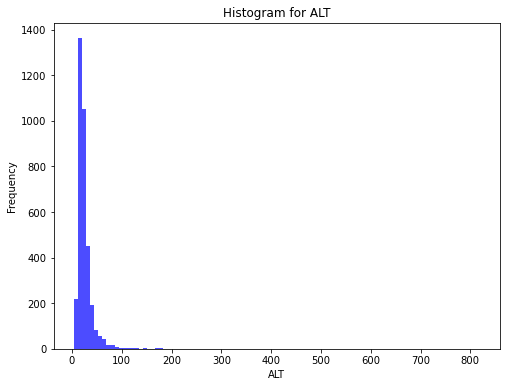

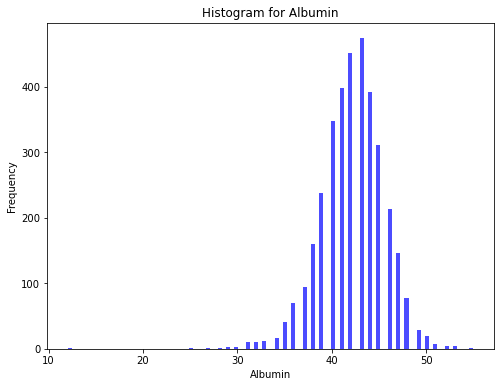

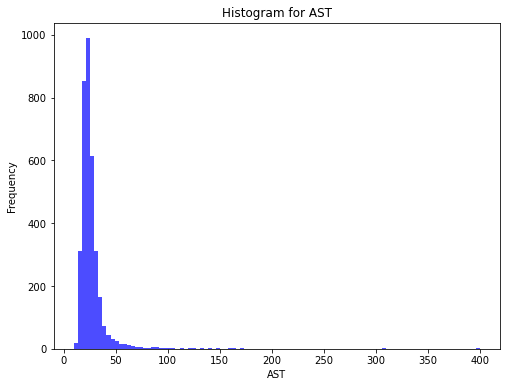

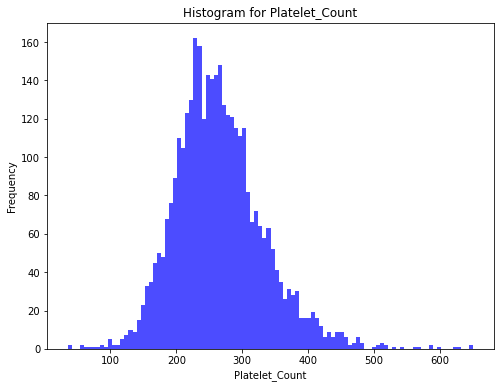

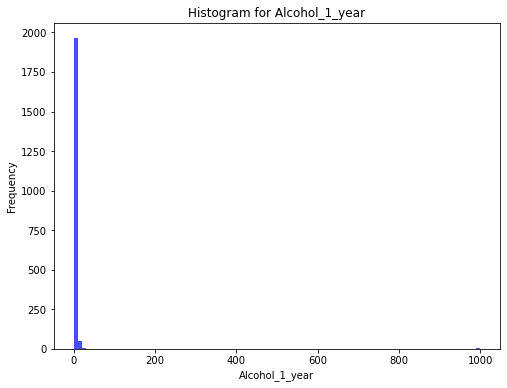

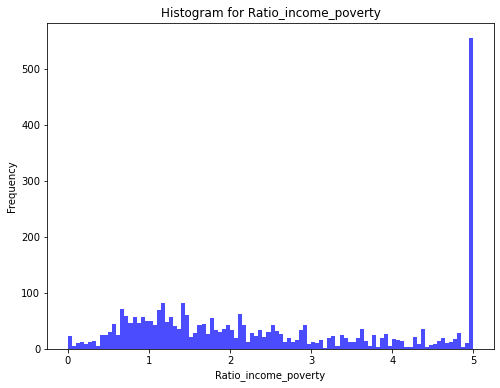

In [77]:
for column in continuous_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(nhanes0708[~nhanes0708[column].isna()][column], bins=100, color='blue', alpha=0.7)
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [78]:
#Impute ALT, AST, PLT, PST with medians
#Impute income poverty ratio with PSU weighted means
#Impute Alcohol 1 year with weighted means
#Delete rows where Categorical features are missing

In [79]:
# Deleting records where categorical columns have missing values
categorical_columns = ['Education_level','Marital_status','liver_condition']

In [80]:
# Drop rows with missing values in specified categorical columns
nhanes0708 = nhanes0708.dropna(subset=categorical_columns)

In [81]:
#Imputing biochemistry variables
continuous_columns = ['ALT', 'Albumin', 'AST', 'Platelet_Count']

In [82]:
# Impute missing values with median
for column in continuous_columns:
    median_value = nhanes0708[column].median()
    nhanes0708[column].fillna(median_value, inplace=True)

In [83]:
#Imputing alcohol_1_year
alcohol_column = 'Alcohol_1_year'
weights_column = 'Two_year_interview_weight'  

In [84]:
# Calculate the weighted mean for Alcohol_1_year
weighted_mean = (nhanes0708[alcohol_column] * nhanes0708[weights_column]).sum() / nhanes0708[weights_column].sum()

In [85]:
# Impute missing values with the weighted mean for Alcohol_1_year
nhanes0708[alcohol_column].fillna(weighted_mean, inplace=True)

In [86]:
nhanes0708.columns

Index(['Respondent_sequence_number', 'Core_Antibody', 'Surface_Antigen',
       'Surface_Antibody', 'Vaccination', 'resp_2', 'Data_release_cycle',
       'Gender', 'Age', 'Race_Ethnicity', 'Veteran_Status', 'Country_of_birth',
       'Citizenship_status', 'Education_level', 'Marital_status',
       'Two_year_interview_weight', 'Two_year_MEC_weight',
       'Masked_variance_PSU', 'Masked_variance_stratum',
       'Ratio_income_poverty', 'No_Insurance', 'Private_Insurance',
       'Governement_Insurance', 'Alcohol_1_year', 'Health_care_1_year',
       'liver_condition', 'Blood_Transfusion', 'Hepatitis_C', 'ALT', 'Albumin',
       'AST', 'Platelet_Count'],
      dtype='object')

In [87]:
nhanes0708['concat'] = nhanes0708['Masked_variance_stratum'].astype(str) + '_' + nhanes0708['Masked_variance_PSU'].astype(str)

In [88]:
nhanes0708['product'] = nhanes0708['Ratio_income_poverty']*nhanes0708['Two_year_interview_weight']

In [89]:
nhanes0708_temp = nhanes0708.groupby('concat').sum()['product'].reset_index()

In [90]:
nhanes0708_temp_2 = nhanes0708.groupby('concat').sum()['Two_year_interview_weight'].reset_index()

In [91]:
nhanes0708_temp_3  = pd.merge(nhanes0708_temp, nhanes0708_temp_2, on="concat", how = "left")

In [92]:
nhanes0708_temp_3['rip'] = nhanes0708_temp_3['product']/nhanes0708_temp_3['Two_year_interview_weight']

In [93]:
nhanes0708_temp_4 = nhanes0708_temp_3[['concat','rip']]

In [94]:
nhanes0708 = pd.merge(nhanes0708,nhanes0708_temp_4, on='concat', how='left')

In [95]:
# Fill missing values in col_to_fill with mapping_value
nhanes0708['Ratio_income_poverty'] = nhanes0708['Ratio_income_poverty'].fillna(nhanes0708['rip'])

In [96]:
nhanes0708 = nhanes0708.drop(columns=['product','rip'])

In [97]:
nhanes0708.replace('Missing','No', inplace=True)

In [98]:
nhanes0708

,Respondent_sequence_number,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,Data_release_cycle,Gender,Age,Race_Ethnicity,Veteran_Status,Country_of_birth,Citizenship_status,Education_level,Marital_status,Two_year_interview_weight,Two_year_MEC_weight,Masked_variance_PSU,Masked_variance_stratum,Ratio_income_poverty,No_Insurance,Private_Insurance,Governement_Insurance,Alcohol_1_year,Health_care_1_year,liver_condition,Blood_Transfusion,Hepatitis_C,ALT,Albumin,AST,Platelet_Count,concat
0,41475.0,Negative,Negative,Negative,No Doses,No Infection,5.0,Female,62.0,5.0,No,US,Citizen,High School Grad/GED or Equivalent,Married,59356.356426,60045.772497,1.0,60.0,1.830000,1,0,0,3.026742,4 to 9,No,No,NaN,26.0,36.0,24.0,366.0,60.0_1.0
1,41477.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,71.0,Non-Hispanic White,Yes,US,Citizen,High School Grad/GED or Equivalent,Married,9935.266183,10074.150074,1.0,67.0,1.500000,0,0,1,3.026742,2 to 3,No,No,NaN,20.0,45.0,20.0,273.0,67.0_1.0
2,41482.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,64.0,Mexican American,No,Other,Not a citizen,9-12th Grade,Married,9811.075078,11602.178638,2.0,65.0,4.010000,0,1,1,4.000000,1,Yes,No,NaN,42.0,45.0,35.0,239.0,65.0_2.0
3,41483.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,66.0,Non-Hispanic Black,Yes,US,Citizen,Some College or AA degree,Married,8058.685296,7920.812275,2.0,66.0,1.140000,0,1,1,3.026742,4 to 9,No,No,NaN,19.0,35.0,23.0,205.0,66.0_2.0
4,41485.0,Negative,Negative,Negative,Don't know,No Infection,5.0,Female,30.0,Other Hispanic,No,Other,Citizen,9-12th Grade,Married,19055.790060,18849.664396,2.0,71.0,1.010000,1,0,0,3.026742,0.0,No,No,NaN,15.0,44.0,17.0,465.0,71.0_2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3551,51610.0,Negative,Negative,Negative,No Doses,No Infection,5.0,Female,69.0,Mexican American,No,Other,Not a citizen,Less Than 9th Grade,Widowed,4865.131732,4805.998976,2.0,74.0,3.151228,0,0,1,1.000000,13 or more,No,No,NaN,24.0,44.0,21.0,260.0,74.0_2.0
3552,51611.0,Negative,Negative,Negative,No Doses,No Infection,5.0,Female,55.0,Non-Hispanic White,Yes,Other,Citizen,Some College or AA degree,Divorced,87778.705525,90642.023851,1.0,65.0,4.950000,0,1,1,1.000000,13 or more,No,No,NaN,16.0,43.0,17.0,431.0,65.0_1.0
3553,51618.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,48.0,Non-Hispanic White,No,US,Citizen,College Graduate or above,Married,83207.549908,84181.537996,1.0,74.0,3.830000,0,1,1,3.026742,0.0,No,No,NaN,20.0,46.0,22.0,310.0,74.0_1.0
3554,51619.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,61.0,Mexican American,No,Other,Citizen,Less Than 9th Grade,Married,5197.083889,5390.204907,2.0,71.0,2.750000,1,0,0,6.000000,2 to 3,No,No,NaN,25.0,45.0,22.0,228.0,71.0_2.0


In [99]:
for i in list(nhanes0708.columns):
    print(i, ":", nhanes0708[(nhanes0708[i]=='missing') | (nhanes0708[i].isna())].shape[0]*100.0/nhanes0708.shape[0])

Respondent_sequence_number : 0.0
Core_Antibody : 0.0
Surface_Antigen : 0.0
Surface_Antibody : 0.0
Vaccination : 0.0
resp_2 : 0.0
Data_release_cycle : 0.0
Gender : 0.0
Age : 0.0
Race_Ethnicity : 0.0
Veteran_Status : 0.0
Country_of_birth : 0.0
Citizenship_status : 0.0281214848143982
Education_level : 0.7592800899887514
Marital_status : 0.7592800899887514
Two_year_interview_weight : 0.0
Two_year_MEC_weight : 0.0
Masked_variance_PSU : 0.0
Masked_variance_stratum : 0.0
Ratio_income_poverty : 0.0
No_Insurance : 0.0
Private_Insurance : 0.0
Governement_Insurance : 0.0
Alcohol_1_year : 0.0
Health_care_1_year : 0.0
liver_condition : 0.7592800899887514
Blood_Transfusion : 0.0
Hepatitis_C : 98.56580427446569
ALT : 0.0
Albumin : 0.0
AST : 0.0
Platelet_Count : 0.0
concat : 0.0


In [100]:
nhanes0708

,Respondent_sequence_number,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,Data_release_cycle,Gender,Age,Race_Ethnicity,Veteran_Status,Country_of_birth,Citizenship_status,Education_level,Marital_status,Two_year_interview_weight,Two_year_MEC_weight,Masked_variance_PSU,Masked_variance_stratum,Ratio_income_poverty,No_Insurance,Private_Insurance,Governement_Insurance,Alcohol_1_year,Health_care_1_year,liver_condition,Blood_Transfusion,Hepatitis_C,ALT,Albumin,AST,Platelet_Count,concat
0,41475.0,Negative,Negative,Negative,No Doses,No Infection,5.0,Female,62.0,5.0,No,US,Citizen,High School Grad/GED or Equivalent,Married,59356.356426,60045.772497,1.0,60.0,1.830000,1,0,0,3.026742,4 to 9,No,No,NaN,26.0,36.0,24.0,366.0,60.0_1.0
1,41477.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,71.0,Non-Hispanic White,Yes,US,Citizen,High School Grad/GED or Equivalent,Married,9935.266183,10074.150074,1.0,67.0,1.500000,0,0,1,3.026742,2 to 3,No,No,NaN,20.0,45.0,20.0,273.0,67.0_1.0
2,41482.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,64.0,Mexican American,No,Other,Not a citizen,9-12th Grade,Married,9811.075078,11602.178638,2.0,65.0,4.010000,0,1,1,4.000000,1,Yes,No,NaN,42.0,45.0,35.0,239.0,65.0_2.0
3,41483.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,66.0,Non-Hispanic Black,Yes,US,Citizen,Some College or AA degree,Married,8058.685296,7920.812275,2.0,66.0,1.140000,0,1,1,3.026742,4 to 9,No,No,NaN,19.0,35.0,23.0,205.0,66.0_2.0
4,41485.0,Negative,Negative,Negative,Don't know,No Infection,5.0,Female,30.0,Other Hispanic,No,Other,Citizen,9-12th Grade,Married,19055.790060,18849.664396,2.0,71.0,1.010000,1,0,0,3.026742,0.0,No,No,NaN,15.0,44.0,17.0,465.0,71.0_2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3551,51610.0,Negative,Negative,Negative,No Doses,No Infection,5.0,Female,69.0,Mexican American,No,Other,Not a citizen,Less Than 9th Grade,Widowed,4865.131732,4805.998976,2.0,74.0,3.151228,0,0,1,1.000000,13 or more,No,No,NaN,24.0,44.0,21.0,260.0,74.0_2.0
3552,51611.0,Negative,Negative,Negative,No Doses,No Infection,5.0,Female,55.0,Non-Hispanic White,Yes,Other,Citizen,Some College or AA degree,Divorced,87778.705525,90642.023851,1.0,65.0,4.950000,0,1,1,1.000000,13 or more,No,No,NaN,16.0,43.0,17.0,431.0,65.0_1.0
3553,51618.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,48.0,Non-Hispanic White,No,US,Citizen,College Graduate or above,Married,83207.549908,84181.537996,1.0,74.0,3.830000,0,1,1,3.026742,0.0,No,No,NaN,20.0,46.0,22.0,310.0,74.0_1.0
3554,51619.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,61.0,Mexican American,No,Other,Citizen,Less Than 9th Grade,Married,5197.083889,5390.204907,2.0,71.0,2.750000,1,0,0,6.000000,2 to 3,No,No,NaN,25.0,45.0,22.0,228.0,71.0_2.0


In [101]:
# Replace "missing" with NaN
nhanes0708.replace(np.nan,'No',inplace=True)

# Drop rows with any missing values
nhanes0708 = nhanes0708.dropna()

# Display the cleaned DataFrame
nhanes0708

,Respondent_sequence_number,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,Data_release_cycle,Gender,Age,Race_Ethnicity,Veteran_Status,Country_of_birth,Citizenship_status,Education_level,Marital_status,Two_year_interview_weight,Two_year_MEC_weight,Masked_variance_PSU,Masked_variance_stratum,Ratio_income_poverty,No_Insurance,Private_Insurance,Governement_Insurance,Alcohol_1_year,Health_care_1_year,liver_condition,Blood_Transfusion,Hepatitis_C,ALT,Albumin,AST,Platelet_Count,concat
0,41475.0,Negative,Negative,Negative,No Doses,No Infection,5.0,Female,62.0,5.0,No,US,Citizen,High School Grad/GED or Equivalent,Married,59356.356426,60045.772497,1.0,60.0,1.830000,1,0,0,3.026742,4 to 9,No,No,No,26.0,36.0,24.0,366.0,60.0_1.0
1,41477.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,71.0,Non-Hispanic White,Yes,US,Citizen,High School Grad/GED or Equivalent,Married,9935.266183,10074.150074,1.0,67.0,1.500000,0,0,1,3.026742,2 to 3,No,No,No,20.0,45.0,20.0,273.0,67.0_1.0
2,41482.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,64.0,Mexican American,No,Other,Not a citizen,9-12th Grade,Married,9811.075078,11602.178638,2.0,65.0,4.010000,0,1,1,4.000000,1,Yes,No,No,42.0,45.0,35.0,239.0,65.0_2.0
3,41483.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,66.0,Non-Hispanic Black,Yes,US,Citizen,Some College or AA degree,Married,8058.685296,7920.812275,2.0,66.0,1.140000,0,1,1,3.026742,4 to 9,No,No,No,19.0,35.0,23.0,205.0,66.0_2.0
4,41485.0,Negative,Negative,Negative,Don't know,No Infection,5.0,Female,30.0,Other Hispanic,No,Other,Citizen,9-12th Grade,Married,19055.790060,18849.664396,2.0,71.0,1.010000,1,0,0,3.026742,0.0,No,No,No,15.0,44.0,17.0,465.0,71.0_2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3551,51610.0,Negative,Negative,Negative,No Doses,No Infection,5.0,Female,69.0,Mexican American,No,Other,Not a citizen,Less Than 9th Grade,Widowed,4865.131732,4805.998976,2.0,74.0,3.151228,0,0,1,1.000000,13 or more,No,No,No,24.0,44.0,21.0,260.0,74.0_2.0
3552,51611.0,Negative,Negative,Negative,No Doses,No Infection,5.0,Female,55.0,Non-Hispanic White,Yes,Other,Citizen,Some College or AA degree,Divorced,87778.705525,90642.023851,1.0,65.0,4.950000,0,1,1,1.000000,13 or more,No,No,No,16.0,43.0,17.0,431.0,65.0_1.0
3553,51618.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,48.0,Non-Hispanic White,No,US,Citizen,College Graduate or above,Married,83207.549908,84181.537996,1.0,74.0,3.830000,0,1,1,3.026742,0.0,No,No,No,20.0,46.0,22.0,310.0,74.0_1.0
3554,51619.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,61.0,Mexican American,No,Other,Citizen,Less Than 9th Grade,Married,5197.083889,5390.204907,2.0,71.0,2.750000,1,0,0,6.000000,2 to 3,No,No,No,25.0,45.0,22.0,228.0,71.0_2.0


In [104]:
# Replace "missing" with NaN
nhanes0708.replace("missing",np.nan,inplace=True)

# Drop rows with any missing values
nhanes0708 = nhanes0708.dropna()

# Display the cleaned DataFrame
nhanes0708

,Respondent_sequence_number,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,Data_release_cycle,Gender,Age,Race_Ethnicity,Veteran_Status,Country_of_birth,Citizenship_status,Education_level,Marital_status,Two_year_interview_weight,Two_year_MEC_weight,Masked_variance_PSU,Masked_variance_stratum,Ratio_income_poverty,No_Insurance,Private_Insurance,Governement_Insurance,Alcohol_1_year,Health_care_1_year,liver_condition,Blood_Transfusion,Hepatitis_C,ALT,Albumin,AST,Platelet_Count,concat
0,41475.0,Negative,Negative,Negative,No Doses,No Infection,5.0,Female,62.0,5.0,No,US,Citizen,High School Grad/GED or Equivalent,Married,59356.356426,60045.772497,1.0,60.0,1.830000,1,0,0,3.026742,4 to 9,No,No,No,26.0,36.0,24.0,366.0,60.0_1.0
1,41477.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,71.0,Non-Hispanic White,Yes,US,Citizen,High School Grad/GED or Equivalent,Married,9935.266183,10074.150074,1.0,67.0,1.500000,0,0,1,3.026742,2 to 3,No,No,No,20.0,45.0,20.0,273.0,67.0_1.0
2,41482.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,64.0,Mexican American,No,Other,Not a citizen,9-12th Grade,Married,9811.075078,11602.178638,2.0,65.0,4.010000,0,1,1,4.000000,1,Yes,No,No,42.0,45.0,35.0,239.0,65.0_2.0
3,41483.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,66.0,Non-Hispanic Black,Yes,US,Citizen,Some College or AA degree,Married,8058.685296,7920.812275,2.0,66.0,1.140000,0,1,1,3.026742,4 to 9,No,No,No,19.0,35.0,23.0,205.0,66.0_2.0
4,41485.0,Negative,Negative,Negative,Don't know,No Infection,5.0,Female,30.0,Other Hispanic,No,Other,Citizen,9-12th Grade,Married,19055.790060,18849.664396,2.0,71.0,1.010000,1,0,0,3.026742,0.0,No,No,No,15.0,44.0,17.0,465.0,71.0_2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3551,51610.0,Negative,Negative,Negative,No Doses,No Infection,5.0,Female,69.0,Mexican American,No,Other,Not a citizen,Less Than 9th Grade,Widowed,4865.131732,4805.998976,2.0,74.0,3.151228,0,0,1,1.000000,13 or more,No,No,No,24.0,44.0,21.0,260.0,74.0_2.0
3552,51611.0,Negative,Negative,Negative,No Doses,No Infection,5.0,Female,55.0,Non-Hispanic White,Yes,Other,Citizen,Some College or AA degree,Divorced,87778.705525,90642.023851,1.0,65.0,4.950000,0,1,1,1.000000,13 or more,No,No,No,16.0,43.0,17.0,431.0,65.0_1.0
3553,51618.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,48.0,Non-Hispanic White,No,US,Citizen,College Graduate or above,Married,83207.549908,84181.537996,1.0,74.0,3.830000,0,1,1,3.026742,0.0,No,No,No,20.0,46.0,22.0,310.0,74.0_1.0
3554,51619.0,Negative,Negative,Negative,No Doses,No Infection,5.0,male,61.0,Mexican American,No,Other,Citizen,Less Than 9th Grade,Married,5197.083889,5390.204907,2.0,71.0,2.750000,1,0,0,6.000000,2 to 3,No,No,No,25.0,45.0,22.0,228.0,71.0_2.0


In [105]:
for i in list(nhanes0708.columns):
    print(i, ":", nhanes0708[(nhanes0708[i]=='missing') | (nhanes0708[i].isna())].shape[0]*100.0/nhanes0708.shape[0])

Respondent_sequence_number : 0.0
Core_Antibody : 0.0
Surface_Antigen : 0.0
Surface_Antibody : 0.0
Vaccination : 0.0
resp_2 : 0.0
Data_release_cycle : 0.0
Gender : 0.0
Age : 0.0
Race_Ethnicity : 0.0
Veteran_Status : 0.0
Country_of_birth : 0.0
Citizenship_status : 0.0
Education_level : 0.0
Marital_status : 0.0
Two_year_interview_weight : 0.0
Two_year_MEC_weight : 0.0
Masked_variance_PSU : 0.0
Masked_variance_stratum : 0.0
Ratio_income_poverty : 0.0
No_Insurance : 0.0
Private_Insurance : 0.0
Governement_Insurance : 0.0
Alcohol_1_year : 0.0
Health_care_1_year : 0.0
liver_condition : 0.0
Blood_Transfusion : 0.0
Hepatitis_C : 0.0
ALT : 0.0
Albumin : 0.0
AST : 0.0
Platelet_Count : 0.0
concat : 0.0


In [106]:
nhanes0708.shape

(3528, 33)